<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Nonlinear diffusion exercise with Landlab

This notebook was created by Nicole Gasparini at Tulane University.

<hr>
For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a>
<hr>


**What is this notebook?**

This notebook illustrates the evolution of landforms dominated by processes that result in nonlinear diffusion of sediment. In other words, the downhill flow of soil is nonlinearly proportional to the (downhill) gradient of the land surface.

The notebook first illustrates a simple example of an evolving hillslope. We then provide a number of exercises for students to do on their own. This set of exercises is recomended for students in a quantitative geomorphology class, who have been introduced to a nonlinear diffusion equation in class. 

**Application of linear diffusion transport law:**

In settings where slopes are steep and relatively rapid sediment transport occurs as slope steepen (think slope failure, landsliding), a transport law similar to the following may apply:
\begin{equation}
q_s = -D \bigg( 1 + \Big( \frac{S}{S_c} \Big)^2 + \Big( \frac{S}{S_c} \Big)^4 + ... + \Big( \frac{S}{S_c} \Big)^{2(n-1)} \bigg)
\end{equation}
where ${q}_s$ is the transport rate with dimensions of $L^2T^{-1}$;  $D$ is a transport coefficient with dimensions of $L^2T^{-1}$; $S$ is slope ($-\nabla z$, where $z$ is elevation, and it is assumed that distance is increasing downslope); $S_c$ is the critical slope; and $n$ is the number of terms. This equation is Ganti et al., (2012) https://dx.doi.org/10.1029/2011jf002181. (The default behavior of the Landlab component will be to use two terms in the equation above. That is what is explored in this notebook.)
 
Changes in elevation, or erosion, are calculated from conservation of mass:
\begin{equation}
\frac{dz}{dt} = U-\nabla q_s
\end{equation}
where $U$ is the rock uplift rate, with dimensions $LT^{-1}$.

**How will we explore this with Landlab?**

We will use the Landlab component *TaylorNonLinearDiffuser*, which implements the equations above, to explore how hillslopes evolve when nonlinear diffusion describes hillslope sediment transport. We will explore the steady state form of the landscape and sensitivity to parameters. Here steady state is defined as erosion rate equal to rock uplift rate.

The first example illustrates how to set-up the model and evolve a hillslope to steady state, along with how to plot some variables of interest. For more information on hillslope sediment transport laws, this paper is a great overview:

Roering, Joshua J. (2008) "How well can hillslope evolution models “explain” topography? Simulating soil transport and production with high-resolution topographic data." Geological Society of America Bulletin.

Based on the first example, you are asked to first think about what will happen as you change a parameter, and then you explore this numerically by changing the code.

Start at the top by reading each block of text and sequentially running each code block (shift - enter OR got to the _Cell_ pulldown menu at the top and choose _Run Cells_). 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.) 

**Now on to the code example**

Import statements. You should not need to edit this.

In [ ]:
# below is to make plots show up in the notebook
%matplotlib inline

In [2]:
# Code Block 1

import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, xlim, title, xlabel, ylabel, ylim

from landlab.plot.imshow import imshow_grid

We will create a grid with 41 rows and 5 columns, and dx is 5 m (a long, narrow, hillslope). The initial elevation is 0 at all nodes.

We set-up boundary conditions so that material can leave the hillslope at the two short ends.

In [3]:
# Code Block 2

# setup grid
from landlab import RasterModelGrid

mg = RasterModelGrid((41, 5), 5.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# set boundary condition.
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

Now we import and initialize the *LinearDiffuser* component. 

In [ ]:
# Code Block 3

from landlab.components import TaylorNonLinearDiffuser

D = 0.01  # initial value of 0.01 m^2/yr
Sc = 0.5  # critical slope value, units of m/m
nonlin_diffuse = TaylorNonLinearDiffuser(mg, linear_diffusivity=D, slope_crit=Sc, dynamic_dt=True)

We now initialize a few more parameters.

In [ ]:
# Code Block 4

# Uniform rate of rock uplift
uplift_rate = 0.0001  # meters/year, originally set to 0.0001

# Total time in years that the model will run for.
runtime = 1000000  # years, originally set to 1,000,000

# Stability criteria for timestep dt.  Coefficient can be changed
# depending on our tolerance for stability vs tolerance for run time.
dt = 0.5 * mg.dx * mg.dx / D

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
time_counter = 0

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

Now we figure out the analytical solution for the elevation of the steady-state profile using *linear diffusion*.

In [6]:
# Code Block 5

ys = np.arange(mg.number_of_node_rows * mg.dx - mg.dx)

# location of divide or ridge crest -> middle of grid
# based on boundary conds.
divide_loc = (mg.number_of_node_rows * mg.dx - mg.dx) / 2

# half-width of the ridge
half_width = (mg.number_of_node_rows * mg.dx - mg.dx) / 2

# analytical solution for elevation under linear diffusion at steady state
zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

Before we evolve the landscape, let's look at the initial topography. (This is just verifying that it is flat with zero elevation.)

Text(0.5, 1.0, 'initial topographic cross section')

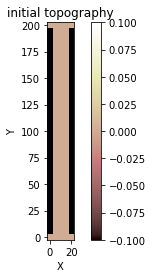

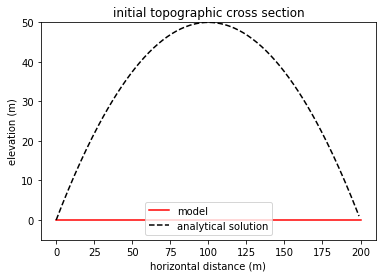

In [7]:
# Code Block 6

figure(1)
imshow_grid(mg, "topographic__elevation")
title("initial topography")
figure(2)
elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "r-", label="model")
plot(ys, zs, "k--", label="analytical solution")
ylim((-5, 50))  # may want to change upper limit if D changes
xlabel("horizontal distance (m)")
ylabel("elevation (m)")
legend(loc="lower center")
title("initial topographic cross section")

Now we are ready to evolve the landscape.

Below is the time loop that does all the calculations. 

maximum elevation is  27.1148272148


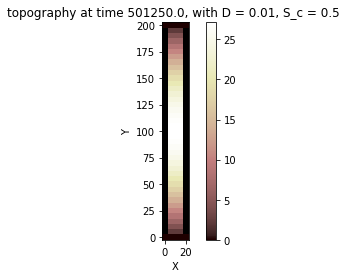

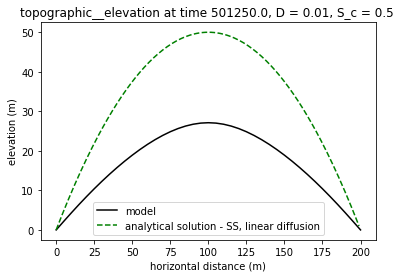

In [8]:
# Code Block 7

for i in range(nt):
    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
    nonlin_diffuse.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first two lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        imshow_grid(mg, "topographic__elevation")
        title("topography at time %s, with D = %s, S_c = %s " % (time_counter, D, Sc))
        figure(2)
        elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        plot(ys_grid, elev_rast[:, 2], "k-", label="model")
        plot(ys, zs, "g--", label="analytical solution - SS, linear diffusion")
        xlabel("horizontal distance (m)")
        ylabel("elevation (m)")
        legend(loc="lower center")
        title("topographic__elevation at time %s, D = %s, S_c = %s " % (time_counter, D, Sc))
        max_elev = np.max(elev_rast[:, 2]) # shouldn't this be outside?
        print("maximum elevation is ", max_elev)

Now we plot the final cross-section.

Text(0.5, 1.0, 'topographic cross section at time 1000000.0, with D = 0.01')

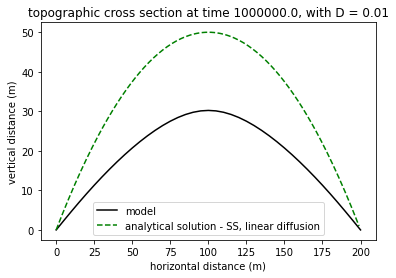

In [9]:
# Code Block 8

elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "k-", label="model")
plot(ys, zs, "g--", label="analytical solution - SS, linear diffusion")
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
legend(loc="lower center")
title("topographic cross section at time %s, with D = %s" % (time_counter, D))

Now we plot the steepest slope in the downward direction across the landscape.

(To calculate the steepest slope at a location, we need to route flow across the landscape.)

maximum slope is  0.470977990084


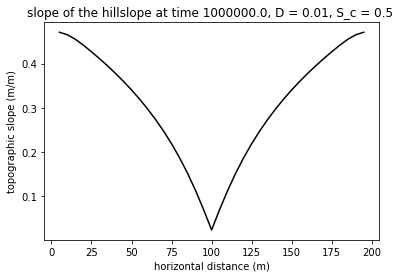

In [10]:
# Code Block 9

from landlab.components import FlowAccumulator

fr = FlowAccumulator(mg)  # intializing flow routing
fr.run_one_step()
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title("slope of the hillslope at time %s, D = %s, S_c = %s " % (time_counter, D, Sc))
max_slope = np.max(mg.at_node["topographic__steepest_slope"][mg.core_nodes])
print("maximum slope is ", max_slope)

We can also plot a map of relief across the landscape. We will normalize by the size of the relief window.

In [ ]:
# Code Block 10

from landlab.utils import window_statistic

radius = 15

relief = window_statistic.calculate_window_statistic(mg,"topographic__elevation", np.ptp,search_radius=radius, calc_on_closed_nodes=False)

figure(1)
imshow_grid(mg, relief/radius)
title("map of local relief with window radius = %s" % (radius))

figure(2)
ax=plot(
    mg.node_y[mg.core_nodes],
    relief[mg.core_nodes]/radius,
    "k-",
)
xlim([radius, np.max(mg.node_y)-radius])
xlabel("horizontal distance (m)")
ylabel("relief (m/m)")
title("relief of the hillslope at time %s, D = %s, S_c = %s, window = %s " % (time_counter, D, Sc, radius))

Has the landscape reached steady state yet? How do you know?

**What to do and hand in:**

This assignment is more "freeform" than the last one.

1. From your experience with the linear diffusion model, you now know that if diffusivity is fixed, then a hillslope becomes steeper if the uplift/erosion rate is increased or the diffusivity is decreased. Run a few model cases to illustrate the same behavior holds at steady state using the nonlinear diffusion model. Describe the model sensitivity to erosion rate and diffusivity using plots and text. Is the nonlinear model as sensitive to changes in these paramaters as the linear model? Make sure it is clear how you are making your assesment of what it means to be more or less sensitive.
2. How does changing $S_c$ impact hillslope form at steady state? Do some model runs to illustrate hillslope sensitivity to $S_c$. Make sure you include plots and text to describe your findings.
3. If relief is defined as the difference between maximum and minimum elevation, do hillslopes evolved with the linear or nonlinear model have more relief? Compare hillslopes with the same $D$ value between the two models. Use plots and text to support your answer. (This is a very unconstrained question. I'm just trying to get you thinking about the slopes and relief produced using the different models. You may find that some hillslope forms don't seem realistic. This is a model, and that is OK.)
4. On two hillslopes with different $S_c$, but the same erosion rate and $D$, explore the patterns of relief produced at steady state (Code Block 10). How does the radius over which relief is calculated impact the patterns of relief you see across the hillslope? Does the pattern change with the different values of $S_c$? Again, this is a very unconstrained question. Explore, describe what you find using full sentences and plots.